# The Radiative Forcing Barchart™

An IPCC classic since 2007. Maybe earlier.

Create a combined figure including the time history.

In [1]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import xarray as xr
from matplotlib import gridspec

import os

In [2]:
ds = xr.load_dataset('../output/ERF_ensemble.nc')

In [3]:
variables = list(ds.keys())

In [4]:
df = pd.read_csv('../output/ERF_best_1750-2023.csv', index_col=0)

## Non-aggregated variables

In [5]:
best = {}
unc = {}

for variable in [
    'CO2', 
    'CH4', 
    'N2O', 
    'aerosol-radiation_interactions', 
    'aerosol-cloud_interactions', 
    'O3',
    'contrails',
    'land_use',
    'BC_on_snow',
    'H2O_stratospheric',
    'solar',
    'volcanic'
]:
    best[variable] = df[variable].values.squeeze()
    unc[variable] = np.percentile(ds[variable], (5, 95), axis=1)

## Aggregated variables

In [6]:
best['aerosol']     = np.zeros((274))
best['nonco2wmghg'] = np.zeros((274))
best['halogen']     = np.zeros((274))
best['anthro']      = np.zeros((274))
best['total']       = np.zeros((274))
best['minor']       = np.zeros((274))

for variable in tqdm(variables):
    best['total'] = best['total'] + df[variable].values
    if variable not in ['solar', 'volcanic']:
        best['anthro'] = best['anthro'] + df[variable].values
    if variable not in [
        'solar', 'volcanic', 'aerosol-radiation_interactions', 'aerosol-cloud_interactions',
        'O3', 'H2O_stratospheric', 'contrails', 'BC_on_snow', 'land_use', 'CO2'
    ]:
        best['nonco2wmghg'] = best['nonco2wmghg'] + df[variable].values
        if variable not in ['CH4', 'N2O']:
            best['halogen'] = best['halogen'] + df[variable].values
    if variable in ['H2O_stratospheric', 'contrails', 'BC_on_snow', 'land_use']:
        best['minor'] = best['minor'] + df[variable].values
    if variable in ['aerosol-radiation_interactions', 'aerosol-cloud_interactions']:
        best['aerosol'] = best['aerosol'] + df[variable].values

  0%|          | 0/61 [00:00<?, ?it/s]

In [7]:
aerosol     = np.zeros((274, 100000))
nonco2wmghg = np.zeros((274, 100000))
halogen     = np.zeros((274, 100000))
anthro      = np.zeros((274, 100000))
total       = np.zeros((274, 100000))
minor       = np.zeros((274, 100000))

for variable in tqdm(variables):
    total = total + ds[variable]
    if variable not in ['solar', 'volcanic']:
        anthro = anthro + ds[variable]
    if variable not in [
        'solar', 'volcanic', 'aerosol-radiation_interactions', 'aerosol-cloud_interactions',
        'O3', 'H2O_stratospheric', 'contrails', 'BC_on_snow', 'land_use', 'CO2'
    ]:
        nonco2wmghg = nonco2wmghg + ds[variable]
        if variable not in ['CH4', 'N2O']:
            halogen = halogen + ds[variable]
    if variable in ['H2O_stratospheric', 'contrails', 'BC_on_snow', 'land_use']:
        minor = minor + ds[variable]
    if variable in ['aerosol-radiation_interactions', 'aerosol-cloud_interactions']:
        aerosol = aerosol + ds[variable]

  0%|          | 0/61 [00:00<?, ?it/s]

In [8]:
df_best = pd.DataFrame(best, index=np.arange(1750.5, 2024))
df_best.to_csv('../output/ERF_best_aggregates_1750-2023.csv')

In [9]:
unc['aerosol'] = np.percentile(aerosol, (5, 95), axis=1)
unc['nonco2wmghg'] = np.percentile(nonco2wmghg, (5, 95), axis=1)
unc['halogen'] = np.percentile(halogen, (5, 95), axis=1)
unc['anthro'] = np.percentile(anthro, (5, 95), axis=1)
unc['total'] = np.percentile(total, (5, 95), axis=1)
unc['minor'] = np.percentile(minor, (5, 95), axis=1)

In [10]:
df_p05 = pd.DataFrame({key: value[0] for key, value in unc.items()}, index=np.arange(1750.5, 2024))
df_p05.to_csv('../output/ERF_p05_aggregates_1750-2023.csv')
df_p05 = pd.DataFrame({key: value[1] for key, value in unc.items()}, index=np.arange(1750.5, 2024))
df_p05.to_csv('../output/ERF_p95_aggregates_1750-2023.csv')

In [11]:
pl.rcParams['figure.figsize'] = (18/2.54, 10/2.54)
pl.rcParams['font.size'] = 11
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.major.left'] = True
pl.rcParams['ytick.major.size'] = 0
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 150

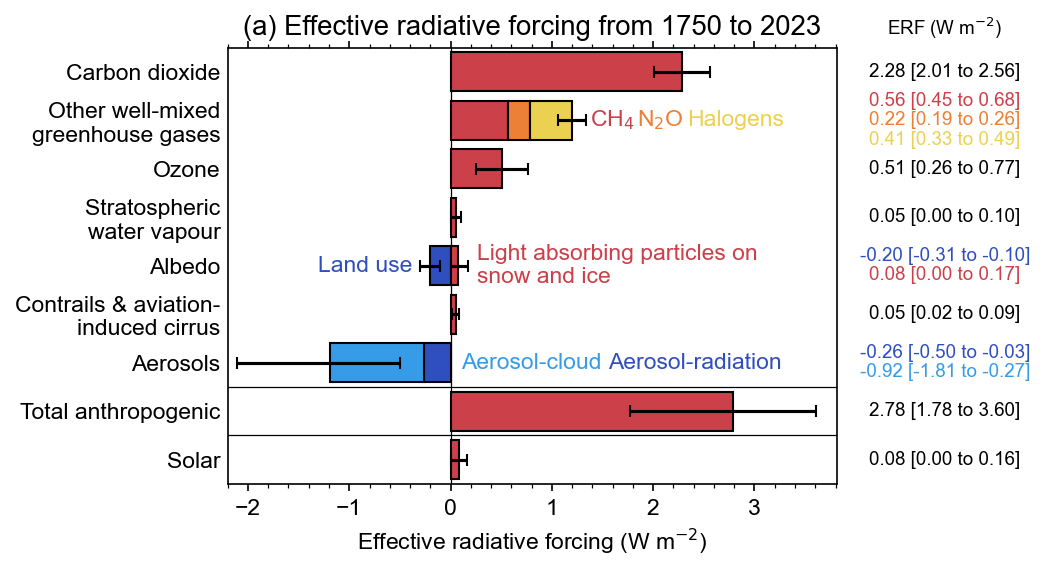

In [12]:
gs = gridspec.GridSpec(1,2, width_ratios=[5,1])
ax = pl.subplot(gs[0,0])

#hot = ['#de2d26','#fc9274','#fee0d2']
hot = ['#cc404a','#ed8037','#ecd151']
cool=['#304fbf','#369ce8']

ax.barh(0, best['CO2'][-1], color=hot[0], xerr=abs(best['CO2'][-1]-unc['CO2'][:,-1])[:,None], capsize=3, lw=1, edgecolor='k', zorder=3)
ax.barh(-1, best['CH4'][-1], color=hot[0], lw=1, edgecolor='k', zorder=3)
ax.barh(-1, best['N2O'][-1], color=hot[1], left=best['CH4'][-1], lw=1, edgecolor='k', zorder=3)
ax.barh(-1, best['halogen'][-1], color=hot[2], left=best['CH4'][-1]+best['N2O'][-1], xerr=abs(best['nonco2wmghg'][-1]-unc['nonco2wmghg'][:,-1])[:,None], capsize=3, lw=1, edgecolor='k', zorder=3)
ax.barh(-2, best['O3'][-1], xerr=abs(best['O3'][-1]-unc['O3'][:,-1])[:,None], color=hot[0], capsize=3, lw=1, edgecolor='k', zorder=3)
ax.barh(-3, best['H2O_stratospheric'][-1], color=hot[0], xerr=abs(best['H2O_stratospheric'][-1]-unc['H2O_stratospheric'][:,-1])[:,None], capsize=3, lw=1, edgecolor='k', zorder=3)
ax.barh(-4, best['land_use'][-1], color=cool[0], xerr=abs(best['land_use'][-1]-unc['land_use'][:,-1])[:,None], capsize=3, lw=1, edgecolor='k', zorder=3)
ax.barh(-4, best['BC_on_snow'][-1], color=hot[0], xerr=abs(best['BC_on_snow'][-1]-unc['BC_on_snow'][:,-1])[:,None], capsize=3, lw=1, edgecolor='k', zorder=3)
ax.barh(-5, best['contrails'][-1], color=hot[0], xerr=abs(best['contrails'][-1]-unc['contrails'][:,-1])[:,None], capsize=3, lw=1, edgecolor='k', zorder=3)
ax.barh(-6, best['aerosol-radiation_interactions'][-1], color=cool[0], lw=1, edgecolor='k', zorder=3)
ax.barh(-6, best['aerosol-cloud_interactions'][-1], color=cool[1], left=best['aerosol-radiation_interactions'][-1], xerr=abs(best['aerosol'][-1]-unc['aerosol'][:,-1])[:,None], capsize=3, lw=1, edgecolor='k', zorder=3)
ax.barh(-7, best['anthro'][-1], color=hot[0], xerr=abs(best['anthro'][-1]-unc['anthro'][:,-1])[:,None], capsize=3, lw=1, edgecolor='k', zorder=3)
ax.barh(-8, best['solar'][-1], color=hot[0], xerr=abs(best['solar'][-1]-unc['solar'][:,-1])[:,None], capsize=3, lw=1, edgecolor='k', zorder=3)

ax.text(1.6, -1, 'CH$_4$',ha='center',va='center', color=hot[0])
ax.text(2.07, -1,'N$_2$O',ha='center',va='center', color=hot[1], bbox=dict(facecolor='w', boxstyle='square,pad=0.0', lw=0))
ax.text(2.34, -1, 'Halogens', va='center', color=hot[2], bbox=dict(facecolor='w', boxstyle='square,pad=0.0', lw=0))
ax.text(-0.38,-4, 'Land use', va='center', ha='right', color=cool[0], bbox=dict(facecolor='w', boxstyle='square,pad=0.0', lw=0))
ax.text(0.26, -4, 'Light absorbing particles on\nsnow and ice', va='center', ha='left', color=hot[0], bbox=dict(facecolor='w', boxstyle='square,pad=0.0', lw=0))
ax.text(0.1, -6, 'Aerosol-cloud', va='center', ha='left', color=cool[1], bbox=dict(facecolor='w', boxstyle='square,pad=0.0', lw=0))
ax.text(1.55, -6, 'Aerosol-radiation', va='center', ha='left', color=cool[0], bbox=dict(facecolor='w', boxstyle='square,pad=0.0', lw=0))

ax.set_ylim(-8.5,0.5)
ax.axvline(0, color='k', lw=0.6)
ax.axhline(-6.5, color='k', lw=0.6)
ax.axhline(-7.5, color='k', lw=0.6)
ax.set_yticks(np.arange(-8,1));
#ax.set_xticks(np.arange(-2,4.2,1));
ax.set_xlim(-2.2,3.81)
ax.set_xlabel('Effective radiative forcing (W m$^{-2}$)')
ax.set_title('')
ax.set_yticklabels(['Carbon dioxide','Other well-mixed\ngreenhouse gases','Ozone','Stratospheric\nwater vapour', 'Albedo', 'Contrails & aviation-\ninduced cirrus', 'Aerosols','Total anthropogenic', 'Solar'][::-1]);
ax.set_title('(a) Effective radiative forcing from 1750 to 2023')


# values
ax_values = pl.subplot(gs[0,1])
ax_values.text(0.5,0,'{:.2f} [{:.2f} to {:.2f}]'.format(best['CO2'][-1], unc['CO2'][0,-1], unc['CO2'][1,-1]), ha='center', va='center', size=9)
ax_values.text(0.5,-0.6,'{:.2f} [{:.2f} to {:.2f}]'.format(best['CH4'][-1], unc['CH4'][0,-1], unc['CH4'][1,-1]), ha='center', va='center', size=9, color=hot[0])
ax_values.text(0.5,-1.0,'{:.2f} [{:.2f} to {:.2f}]'.format(best['N2O'][-1], unc['N2O'][0,-1], unc['N2O'][1,-1]), ha='center', va='center', size=9, color=hot[1])
ax_values.text(0.5,-1.4,'{:.2f} [{:.2f} to {:.2f}]'.format(best['halogen'][-1], unc['halogen'][0,-1], unc['halogen'][1,-1]), ha='center', va='center', size=9, color=hot[2])
ax_values.text(0.5,-2,'{:.2f} [{:.2f} to {:.2f}]'.format(best['O3'][-1], unc['O3'][0,-1], unc['O3'][1,-1]), ha='center', va='center', size=9)
ax_values.text(0.5,-3,'{:.2f} [{:.2f} to {:.2f}]'.format(best['H2O_stratospheric'][-1], ( unc['H2O_stratospheric'][0,-1] if abs(unc['H2O_stratospheric'][0,-1]) > 0.005 else abs(unc['H2O_stratospheric'][0,-1]) ), unc['H2O_stratospheric'][1,-1]), ha='center', va='center', size=9)
ax_values.text(0.5,-3.8,'{:.2f} [{:.2f} to {:.2f}]'.format(best['land_use'][-1], unc['land_use'][0,-1], unc['land_use'][1,-1]), ha='center', va='center', size=9, color=cool[0])
ax_values.text(0.5,-4.2,'{:.2f} [{:.2f} to {:.2f}]'.format(best['BC_on_snow'][-1], ( unc['BC_on_snow'][0,-1] if abs(unc['BC_on_snow'][0,-1]) > 0.005 else abs(unc['BC_on_snow'][0,-1]) ), unc['BC_on_snow'][1,-1]), ha='center', va='center', size=9, color=hot[0])
ax_values.text(0.5,-5,'{:.2f} [{:.2f} to {:.2f}]'.format(best['contrails'][-1], unc['contrails'][0,-1], unc['contrails'][1,-1]), ha='center', va='center', size=9)
ax_values.text(0.5,-5.8,'{:.2f} [{:.2f} to {:.2f}]'.format(best['aerosol-radiation_interactions'][-1], unc['aerosol-radiation_interactions'][0,-1], unc['aerosol-radiation_interactions'][1,-1] if abs(unc['aerosol-radiation_interactions'][1,-1]) > 0.005 else abs(unc['aerosol-radiation_interactions'][1,-1]) ), ha='center', va='center', size=9, color=cool[0])
ax_values.text(0.5,-6.2,'{:.2f} [{:.2f} to {:.2f}]'.format(best['aerosol-cloud_interactions'][-1], unc['aerosol-cloud_interactions'][0,-1], unc['aerosol-cloud_interactions'][1,-1]), ha='center', va='center', size=9, color=cool[1])
ax_values.text(0.5,-7,'{:.2f} [{:.2f} to {:.2f}]'.format(best['anthro'][-1], unc['anthro'][0,-1], unc['anthro'][1,-1]), ha='center', va='center', size=9)
ax_values.text(0.5,-8,'{:.2f} [{:.2f} to {:.2f}]'.format(best['solar'][-1], unc['solar'][0,-1], unc['solar'][1,-1]), ha='center', va='center', size=9)
ax_values.set_title('ERF (W m$^{-2}$)', size=9)

ax_values.set_xlim(0,1)
ax_values.set_ylim(-8.5, 0.5)
ax_values.spines['left'].set_visible(False)
ax_values.spines['right'].set_visible(False)
ax_values.spines['bottom'].set_visible(False)
ax_values.spines['top'].set_visible(False)
ax_values.set_yticklabels([])
ax_values.set_xticks([]);

pl.tight_layout()
os.makedirs('../plots', exist_ok=True)
pl.savefig('../plots/ERF_1750-2023.png')
pl.savefig('../plots/ERF_1750-2023.pdf')

In [13]:
pl.rcParams['figure.figsize'] = (18/2.54, 9/2.54)
pl.rcParams['font.size'] = 11
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 150
pl.rcParams['ytick.major.size'] = 3

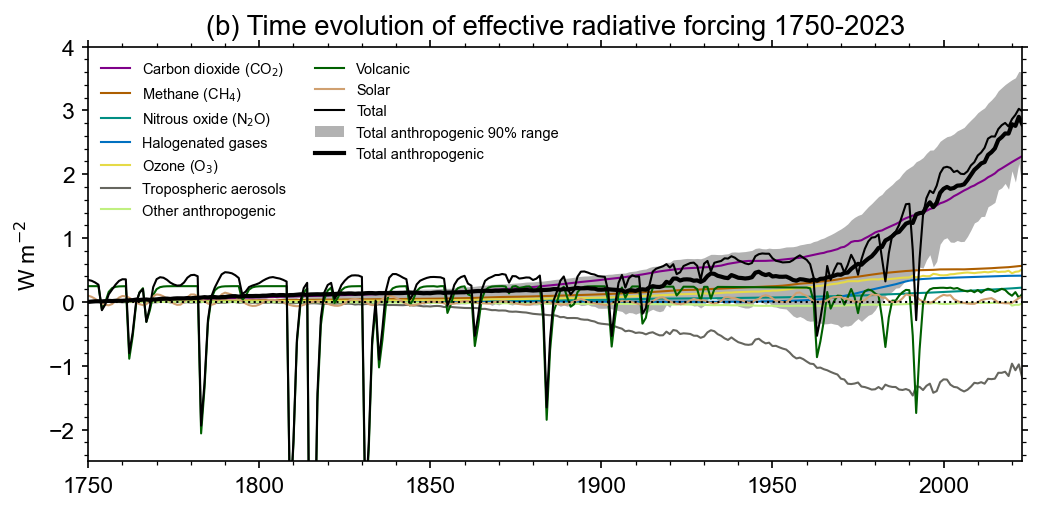

In [14]:
fig, ax = pl.subplots()

year = np.arange(1750, 2024)

species = ['CO2', 'CH4', 'N2O', 'halogen', 'O3', 'aerosol', 'minor', 'volcanic', 'solar', 'total']

colors = {
    'CO2': '#7f0089',
    'CH4': '#ad5e00',
    'N2O': '#008e83',
    'halogen': '#0070c0',
    'aerosol': '#66665f',
    'O3': '#e5da47',
    'minor': '#c0f080',
    'anthro' : '#000000',
    'volcanic': '#006000',
    'solar': '#d0a070',
    'total': '#000000'
}

labels = {
    'CO2': 'Carbon dioxide (CO$_2$)',
    'CH4': 'Methane (CH$_4$)',
    'N2O': 'Nitrous oxide (N$_2$O)',
    'halogen': 'Halogenated gases',
    'aerosol': 'Tropospheric aerosols',
    'O3': 'Ozone (O$_3$)',
    'minor': 'Other anthropogenic',
    'anthro' : 'Total anthropogenic',
    'volcanic': 'Volcanic',
    'solar': 'Solar',
    'total': 'Total'
}

for specie in species:
    ax.plot(year, best[specie], color=colors[specie], lw=1, label=labels[specie])

ax.fill_between(year, unc['anthro'][0,:], unc['anthro'][1,:], color=colors['anthro'], alpha=0.3, lw=0, label='Total anthropogenic 90% range')
ax.plot(year, best['anthro'], color=colors['anthro'], lw=2, label=labels['anthro'])  


ax.plot(0, 0, color='None', lw=0, label='\n')
ax.plot(0, 0, color='None', lw=0, label='\n')


ax.axhline(0, color='k', ls=':', lw=1)
ax.set_xlim(1750,2023)
ax.set_ylim(-2.5, 4)

ax.legend(ncol=2, fontsize=7, frameon=False)

ax.set_title('(b) Time evolution of effective radiative forcing 1750-2023')
ax.set_ylabel('W m$^{-2}$')

pl.tight_layout()
os.makedirs('../plots', exist_ok=True)
pl.savefig('../plots/ERF_timeseries_1750-2023.png')
pl.savefig('../plots/ERF_timeseries_1750-2023.pdf')

In [15]:
ds.close()